In [59]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from skimage.io import imread, imsave, imshow
from sklearn.cross_validation import train_test_split, cross_val_score
import random

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [65]:
train.shape
train_target = train['label'].values
train_data = train.drop('label', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size = 0.8)

/home/skye17/ml/anaconda2/envs/dato-env/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:71: UserWarning: Non-standard image type; displaying image with stretched contrast.
  warnings.warn("Non-standard image type; displaying image with "
/home/skye17/ml/anaconda2/envs/dato-env/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warnings.warn("Low image dynamic range; displaying image with "


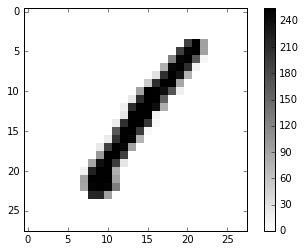

In [4]:
imshow(train_data[0].reshape((28, 28)), 'matplotlib', cmap=plt.cm.binary)

## Custom Neural Network

In [66]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def one_hot(y):
    vec = np.zeros(10)
    vec[y] = 1
    return vec.reshape((vec.size), 1)

class Network(object):
    
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.layers = [np.zeros(y) for y in sizes]
        self.sizes = sizes
        self.biases = np.array([np.random.randn(y, 1) for y in sizes[1:]])
        #print self.biases.shape
        self.weights = np.array([np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])])
        #print self.weights.shape
        
    def feedforward(self, a):
        """Return the output of the network if "a" is input."""
        a_vec = a.reshape((a.size, 1))
        for b, w in zip(self.biases, self.weights):
            a_vec = sigmoid(np.dot(w,a_vec) + b)
        return a_vec
    
    def feedforward_save(self, a):
        a_vec = a.reshape((a.size, 1))
        self.layers[0] = a_vec
        i = 1
        for b, w in zip(self.biases, self.weights):
            a_vec = sigmoid(np.dot(w,a_vec) + b)
            self.layers[i] = a_vec
            i += 1
        return a_vec
        
    def SGD(self, train_data, target,eta = 1.0, eps = 0.000001):
        n, k = train_data.shape
        Q = 0.0
        diff = 1000
        while abs(diff) > eps:
            ind = np.random.choice(range(n), 1)
            x = train_data[ind].reshape((k, 1))
            y_vec = one_hot(target[ind])
            # Прямой и обратный ход
            out = self.feedforward_save(x)
            Q_i = (np.linalg.norm(out - y_vec))**2
            delta_nabla_b, delta_nabla_w = self.backprop(out-y_vec)
            self.weights = [w-eta*nw
                        for w, nw in zip(self.weights, delta_nabla_w)]
            self.biases = [b-eta*nb
                       for b, nb in zip(self.biases, delta_nabla_b)]
            if Q == 0:
                Q = Q_i
            else:
                diff = (Q_i - Q)/n
                Q += diff
         
        
    def backprop(self, out_errors):
        delta_nabla_b = np.array([np.zeros(b.shape) for b in self.biases])
        delta_nabla_w = np.array([np.zeros(w.shape) for w in self.weights])
        errors = np.array([np.zeros(size) for size in self.sizes[1:]])
        pred = self.layers[self.num_layers - 1]
        errors[errors.size - 1] = out_errors
        for i in xrange(errors.size - 1, -1, -1):
            delta_nabla_b[i] = errors[i]*pred*(1-pred)
            delta_nabla_w[i] = np.dot(pred*(1-pred)*errors[i],(self.layers[i]).T)
            if i - 1 >= 0:
                errors[i-1] = np.dot((self.weights[i]).T, pred*(1-pred)*errors[i])
            pred = self.layers[i]
        return delta_nabla_b, delta_nabla_w
    
    def fit(self, X, y):
        self.SGD(X, y)
        return self
    
    def predict(self, X_test):
        print 'Predict'
        return [np.argmax(self.feedforward(x)) for x in X_test]

In [67]:
nn = Network([784, 200,10])
nn.fit(X_train, y_train)
pred = nn.predict(X_test)
accuracy = sum(pred == y_test)*1. / len(y_test)
print accuracy

Predict
0.0965178571429


## Ensemble methods

In [68]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [69]:
clf = RandomForestClassifier(n_estimators  = 100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print accuracy_score(y_test, pred)
#scores = cross_val_score(clf, train_data, train_target, cv = 3, scoring = 'accuracy', n_jobs = -1)
#print np.mean(scores)

0.947827380952


In [71]:
g_clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1)
g_clf.fit(X_train, y_train)
g_pred = g_clf.predict(X_test)
print accuracy_score(y_test, g_pred)
#scores = cross_val_score(g_clf, train_data, train_target, cv = 3, scoring = 'accuracy', n_jobs = -1)
#print np.mean(scores)

KeyboardInterrupt: 

## SVM

In [72]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

In [ ]:
svm = SVC(kernel = 'linear', C = 0.1)
svm.fit(X_train, y_train)
s_pred = svm.predict(X_test)
print accuracy_score(y_test, s_pred)

#params = {'kernel':('linear', 'rbf'), 'C':np.power(10.0, np.arange(-1, 1))}
#grid = GridSearchCV(svm, params, scoring = 'accuracy', n_jobs = -1, cv = 3)
#grid.fit(X_train, y_train)
#print grid.best_estimator_
#print grid.best_params_